# Assignment - Probabilistic Graphical Models
### Year 2020-2021- Semester I
### CCE5225
####  Developed by - Adrian Muscat, 2020
---
Zachary Cauchi, 197999M, BSc CS, Yr I

Submit a pdf version (with the attached plagiarism form) of the final jupyter notebook (as a turn-it-in job on VLE) and the jupyter notebook itself separately (as an assignment job on VLE)

This assignment is to be attempted individually. It is essential that the work you submit and present consists only of your own work; use of copied material will be treated as plagiarism. Discussion is only permitted on general issues, and it is absolutely forbidden to discuss specific details with anyone and/or share results.



In [1]:
import numpy as np
import pickle

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.utils.multiclass import unique_labels
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import pandas
from collections import Counter

import re

def saveAnswer(obj, name):
    answer_file = open(f'saved_answers/{name}.pkl', 'wb')
    pickle.dump(obj, answer_file)
    answer_file.close()

def trimSubClasses(labels):
    pattern = re.compile(r'.+?(?=_\d+(?!.))')
    labels = [[label if not pattern.match(label) else pattern.match(label).group(0) for label in row] for row in labels]
    return labels

In [2]:
infile = open('MLC_data_2020_21.pkl','rb')
data = pickle.load(infile, encoding='latin1')
infile.close()

In [3]:
# Explore dataset
print("First split is into :",data.keys(),'\n')
#
# Lets explore the development set
# This is organised into three lists
print("The three lists are",data['development'].keys(),'\n')
#
# The first element of each list corresponds to the object_labels, 
# geomteric features and output labels for the first example
# ...and so on
# When getting the object labels, trim them accordingly to obtain only the 20 classes
train_obj_labels = trimSubClasses(data['development']['object_labels'])
train_out_labels = data['development']['output_labels']
train_geo_feat = data['development']['geometric_features']
test_obj_labels = trimSubClasses(data['test']['object_labels'])
test_out_labels = data['test']['output_labels']
test_geo_feat = data['test']['geometric_features']

print("There are",len(train_obj_labels), "examples in dev set\n")
print("First example:")
print(train_obj_labels[0])
print(train_out_labels[0])
print(train_geo_feat[0])
print("\nSecond example:")
print(train_obj_labels[1])
print(train_out_labels[1])
print(train_geo_feat[1])
print("\n...")

First split is into : dict_keys(['development', 'test']) 

The three lists are dict_keys(['object_labels', 'output_labels', 'geometric_features']) 

There are 4253 examples in dev set

First example:
['2008_001130.jpg', 'tvmonitor', 'bottle']
['next_to', 'at_the_level_of', 'near']
[ 0.68888274  0.07051991  0.          0.88679245  0.39215686  0.63316053
  0.109375    1.36170213  1.14893617  1.06603774  0.58490566  9.76862745
  0.5546875  -0.30530973]

Second example:
['2008_002210.jpg', 'person', 'diningtable']
['behind', 'opposite', 'near']
[ 0.43984962  0.28696742  0.16        0.40206186  2.36082474  0.48306117
  0.          2.27350427  0.31623932  1.          0.66666667  1.53275109
  0.34962406 -0.33333333]

...


In [4]:
# Example 
# Learning the one-hot encoder

# read all prepositions in multilabel examples and flatten
all_preps=[]
for Y in data['development']['output_labels']:
    for y in Y:
        all_preps.append(y)

values = np.array(all_preps).reshape(len(all_preps),)
print("Shape of values", values.shape,'\n')

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print("Unique labels:\n",label_encoder.classes_,'\n')

# onehot encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print("Example of One-Hot Encoded:\n", onehot_encoded[0],'\n')

# single label encoding for first example
print("Consider first example\n")
b = np.array(data['development']['output_labels'][0])
b = b.reshape(len(b),1)
print("Output Labels:\n",b)
print("\nOne-Hot encoded labels:")
for i in b:
    a = label_encoder.transform(i)
    print(onehot_encoder.transform(a.reshape(-1, 1))[0])



Shape of values (9180,) 

Unique labels:
 ['above' 'against' 'along' 'around' 'at_the_level_of' 'behind' 'beyond'
 'far from' 'in' 'in_front_of' 'near' 'next_to' 'none' 'on' 'opposite'
 'outside_of' 'under'] 

Example of One-Hot Encoded:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 

Consider first example

Output Labels:
 [['next_to']
 ['at_the_level_of']
 ['near']]

One-Hot encoded labels:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


# Section 1: Preparing the data

## Part 1

In [5]:
# 1.a. Computing the mean output label count per example, per dataset (development and test)
average_out_count_train = 0
average_out_count_test = 0

for row in train_out_labels:
    average_out_count_train += len(row)
for row in test_out_labels:
    average_out_count_test += len(row)

average_out_count_train /= len(train_out_labels)
average_out_count_test /= len(test_out_labels)

print('Answer to 1.a:')
print('Mean output labels per row (train set): ', average_out_count_train)
print ('Mean output labels per row (test set): ', average_out_count_test)

saveAnswer({
    'train_average_out': average_out_count_train,
    'test_average_out': average_out_count_test
}, '1a')


Answer to 1.a:
Mean output labels per row (train set):  2.1584763696214435
Mean output labels per row (test set):  2.148496240601504


In [6]:
# 1.b. Flatten the output labels to a 1-d array, computing the distribution for both datasets

# Flatten the labels into a 1D array
flat_out_train = np.concatenate(train_out_labels)
flat_out_test = np.concatenate(test_out_labels)

# Count the numbers of each label
train_out_counts = Counter(flat_out_train)
test_out_counts = Counter(flat_out_test)

# Create dataframes from each counter object above.
train_out_counts_df = pandas.DataFrame.from_dict(train_out_counts, orient='index')
train_out_counts_df.index.name = 'Label distribution in development (train) set'
test_out_counts_df = pandas.DataFrame.from_dict(test_out_counts, orient='index')
test_out_counts_df.index.name = 'Label distribution in test set'

print("Results for 1.b:")
display(train_out_counts_df)
display(test_out_counts_df)

saveAnswer({
    'train_out_counts': train_out_counts_df,
    'test_out_counts': test_out_counts_df
}, '1b')

Results for 1.b:


,0
Label distribution in development (train) set,
next_to,1411
at_the_level_of,926
near,2276
behind,1055
opposite,267
on,359
in_front_of,1102
above,117
under,432


,0
Label distribution in test set,
in_front_of,270
against,136
next_to,359
at_the_level_of,227
near,578
under,101
behind,270
far from,100
on,88


In [7]:
# 1.c. Computing the composite output labels (without flattening like in 1.b) for both datasets.

# Same as above, compute the occurances of each composite output label.
# Unlike above, we first need to transform each row from an unhashable list to a hashable tuple object.
train_cmp_out_counts = Counter(map(tuple, train_out_labels))
test_cmp_out_counts = Counter(map(tuple, test_out_labels))

train_cmp_out_counts_df = pandas.DataFrame.from_dict(train_cmp_out_counts, orient='index')
train_cmp_out_counts_df.index.name = 'Composite output label distribution in development (train) set'
test_cmp_out_counts_df = pandas.DataFrame.from_dict(test_cmp_out_counts, orient='index')
test_cmp_out_counts_df.index.name = 'Composite output label distribution in test set'

print('Results for 1.c:')
display(train_cmp_out_counts_df)
display(test_cmp_out_counts_df)

saveAnswer({
    'train_out_counts': train_cmp_out_counts_df,
    'test_out_counts': test_cmp_out_counts_df
}, '1c')


Results for 1.c:


,0
Composite output label distribution in development (train) set,
"(next_to, at_the_level_of, near)",509
"(behind, opposite, near)",3
"(on,)",135
"(in_front_of, near)",269
"(near, behind)",31
...,...
"(opposite, beyond)",1
"(in_front_of, opposite, under)",1
"(outside_of, next_to, at_the_level_of, near)",1


,0
Composite output label distribution in test set,
"(in_front_of, against)",7
"(next_to, at_the_level_of, near)",132
"(under,)",53
"(at_the_level_of,)",9
"(in_front_of, next_to, at_the_level_of, near)",2
...,...
"(above, next_to, against, behind, near)",1
"(in, on)",1
"(in_front_of, next_to, against)",1


In [8]:
# 1.d Computing the co occurrence probability distribution of the training set.

def computeProbabilityMatrix(matrix):
    # Get all the unique labels from the input matrix.
    labels = np.unique(np.concatenate(train_out_labels))

    # Create the output matrix for the probabilities.
    distribution = pandas.DataFrame(np.zeros(((len(labels)), (len(labels)))), columns=labels, index=labels)
    distribution.index.name = 'co occurrence probabilities'

    # Get all co occurrences
    for sample in matrix:
        for target in labels:
            if target in sample:
                for prep in sample:
                    distribution[target][prep] += 1

    targetCount = 0
    coCount = 0

    # Calculate the probabilities by dividing the 2nd labels co occurrences with the 1st labels total occurrences
    for target in labels:
        for prep in [label for label in labels if label != target]:
            targetCount = distribution[target][target]
            coCount = distribution[prep][target]

            distribution[prep][target] = coCount / targetCount
        
        # Set the targets to 0 to avoid bias
        distribution[target][target] = 0


    return distribution

probDistribution = computeProbabilityMatrix(train_out_labels)

display(probDistribution)

saveAnswer({
    'coOccurrenceProbMatrix': probDistribution
}, '1.d')

,above,against,along,around,at_the_level_of,behind,beyond,far from,in,in_front_of,near,next_to,none,on,opposite,outside_of,under
co occurrence probabilities,,,,,,,,,,,,,,,,,
above,0.000000,0.034188,0.000000,0.000000,0.051282,0.290598,0.017094,0.085470,0.008547,0.119658,0.572650,0.205128,0.0,0.042735,0.051282,0.017094,0.000000
against,0.006745,0.000000,0.008432,0.008432,0.170320,0.119730,0.001686,0.000000,0.021922,0.112985,0.104553,0.229342,0.0,0.345700,0.018550,0.005059,0.236088
along,0.000000,0.072464,0.000000,0.000000,0.260870,0.304348,0.000000,0.014493,0.000000,0.318841,0.782609,0.811594,0.0,0.000000,0.000000,0.000000,0.014493
around,0.000000,0.147059,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.205882
at_the_level_of,0.006479,0.109071,0.019438,0.000000,0.000000,0.032397,0.001080,0.019438,0.000000,0.043197,0.775378,0.812095,0.0,0.000000,0.049676,0.004320,0.005400
behind,0.032227,0.067299,0.019905,0.001896,0.028436,0.000000,0.023697,0.152607,0.000000,0.064455,0.559242,0.188626,0.0,0.000948,0.036019,0.012322,0.036019
beyond,0.047619,0.023810,0.000000,0.000000,0.023810,0.595238,0.000000,0.452381,0.000000,0.238095,0.142857,0.023810,0.0,0.000000,0.071429,0.000000,0.023810
far from,0.026596,0.000000,0.002660,0.000000,0.047872,0.428191,0.050532,0.000000,0.000000,0.468085,0.002660,0.007979,0.0,0.000000,0.026596,0.026596,0.013298
in,0.017857,0.232143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.446429,0.000000,0.000000,0.000000


## Part 2

In [9]:
#2.a Transform the object and geometrical features into an input matrix.

# Trim the file names from the inputs.
train_trimmed = np.array(train_obj_labels)[:, 1:]
test_trimmed = np.array(test_obj_labels)[:, 1:]

# Transform the features into one-hot encoded.
obj_encoder = OneHotEncoder(sparse=False)
obj_encoder = obj_encoder.fit(train_trimmed)
train_input_matrix = obj_encoder.transform(train_trimmed)
test_input_matrix = obj_encoder.transform(test_trimmed)

# Append the geometrical features onto the obtained one-hot features.
train_input_matrix = np.append(train_input_matrix, train_geo_feat, axis=1)
test_input_matrix = np.append(test_input_matrix, test_geo_feat, axis=1)

saveAnswer({
    'train_input_matrix': train_input_matrix,
    'test_input_matrix': test_input_matrix
}, '2.a')

XTrain = train_input_matrix
XTest = test_input_matrix


In [10]:
# 2.b Transform the output features into a multi-label output matrix.

# Use a multi-label binarizer to one-hot encode and reduce multiple features into a single vector.
out_one_hot = MultiLabelBinarizer()
out_one_hot = out_one_hot.fit(train_out_labels)

train_output_matrix = out_one_hot.transform(train_out_labels)
test_output_matrix = out_one_hot.transform(test_out_labels)

saveAnswer({
    'train_output_matrix': train_output_matrix,
    'test_output_matrix': test_output_matrix
}, '2.b')

yTrain = train_output_matrix
yTest = test_output_matrix

## Part 3


In [11]:
# 3 Functions for calculating accuracy metrics

def getMatrix(predictions, truths):
    # Generate a single confusion matrix for all labels
    tp = 0
    fp = 1
    fn = 2
    tn = 3

    # Initialise an empty array.
    matrix = [0, 0, 0, 0]

    # Over each prediction-truth pair, update the confusion matrix for that label.
    for (plabel, tlabel) in np.nditer([predictions, truths], flags=['refs_ok']):
        if plabel == 1 and tlabel == 1: matrix[tp] += 1
        elif plabel == 1 and tlabel == 0: matrix[fp] += 1
        elif plabel == 0 and tlabel == 1: matrix[fn] += 1
        elif plabel == 0 and tlabel == 0: matrix[tn] += 1

    return matrix

def getMatrices(predictions, truths, num_labels):
    # Generate a multi-label confusion matrix
    tp = 0
    fp = 1
    fn = 2
    tn = 3

    # Initialise an empty set of arrays.
    matrices = [[0, 0, 0, 0] for i in range(0, num_labels)]

    it = np.nditer([predictions, truths], flags=['multi_index', 'refs_ok'])

    # Over each prediction-truth pair, update the confusion matrix for that label.
    for plabel, tlabel in it:
        i = it.multi_index[1] # This is the label index
        if plabel == 1 and tlabel == 1: matrices[i][tp] += 1
        elif plabel == 1 and tlabel == 0: matrices[i][fp] += 1
        elif plabel == 0 and tlabel == 1: matrices[i][fn] += 1
        elif plabel == 0 and tlabel == 0: matrices[i][tn] += 1

    return matrices

# 3.a Accuracy (intersection over union)
def getAccuracy(predictions, truths):
    # Get the overall accuracy
    matrix = getMatrix(predictions, truths)
    
    correct = matrix[0] + matrix[3] # tp + tn
    total = sum(matrix) # tp + fp + fn + tn
    
    return correct / total

# 3.b Precision
def getPrecision(predictions, truths):
    # Get the overall precision
    matrix = getMatrix(predictions, truths)

    positives = matrix[0] # tp
    positiveGuesses = matrix[0] + matrix[1] # tp + fp

    return positives / positiveGuesses

# 3.c Recall
def getRecall(predictions, truths):
    # Get the overall recall
    matrix = getMatrix(predictions, truths)

    positives = matrix[0] # tp
    allPositives = matrix[0] + matrix[2] # tp + fn
    
    return positives / allPositives

# 3.d Per-label precision
def getMultiLabelPrecision(predictions, truths):
    # Get the per-label precision
    matrices = getMatrices(predictions, truths, len(truths[0]))

    precisions = [0 for i in range(len(matrices))]

    for i, (tp, fp, fn, tn) in enumerate(matrices):
        p = tp + fp
        precisions[i] = (tp / p) if p != 0 else 1.0
    
    return precisions

# 3.e Per-label recall
def getMultiLabelRecall(predictions, truths):
    # Get the per-label recall
    matrices = getMatrices(predictions, truths, len(truths[0]))

    recalls = [0 for i in range(len(matrices))]
    
    for i, (tp, fp, fn, tn) in enumerate(matrices):
        allPositives = tp + fn
        recalls[i] = (tp / allPositives) if allPositives != 0 else 1.0
    
    return recalls

# Section 2

## Part 1


In [12]:
# 4.a Develop a binary-relevance model set using logistic regression, first trained through cross-validation and then training the best br model on the whole training set.

parameters = [
    {
        'classifier': [LogisticRegression()],
        'classifier__solver': ['sag', 'saga'],
        'classifier__C': [1.0, 0.5, 1.5],
        'classifier__max_iter': [250, 500, 100],
        'classifier__class_weight': [None, 'balanced'],
        'classifier__warm_start': [True],
        'classifier__random_state': [12]
    }
]

clf = GridSearchCV(BinaryRelevance(), parameters, scoring='accuracy', verbose=2, n_jobs=4)

clf.fit(XTrain, yTrain)

display(clf.best_params_, clf.best_score_)
print(f'Best estimator achieved an accuracy score of {clf.best_score_} and trained in {clf.refit_time_:.2f} sec')

predictions = clf.predict(XTest).todense()

saveAnswer({
    'trained_model': clf,
    'predictions': predictions
}, '4.a')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   59.8s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  4.5min
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:  5.3min finished
/home/zachc/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/zachc/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/zachc/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/zachc/.local/lib/python3.8/site-packages/sklearn/linear_model/_s

{'classifier': LogisticRegression(max_iter=500, random_state=12, solver='sag', warm_start=True),
 'classifier__C': 1.0,
 'classifier__class_weight': None,
 'classifier__max_iter': 500,
 'classifier__random_state': 12,
 'classifier__solver': 'sag',
 'classifier__warm_start': True}

0.0338582981958941

Best estimator achieved an accuracy score of 0.0338582981958941 and trained in 10.81 sec


In [13]:
# 4.b Metrics on the trained models from 4.a


# Next, compute the metrics accordingly.
acc = getAccuracy(predictions, yTest)
pre = getPrecision(predictions, yTest)
rec = getRecall(predictions, yTest)
prePerLabel = getMultiLabelPrecision(predictions, yTest)
recPerLabel = getMultiLabelRecall(predictions, yTest)

# In the case of the multi-label metrics, convert them into dataframes for readability.
prePerLabel = pandas.DataFrame(prePerLabel, index=out_one_hot.classes_, columns=['Precision'])
recPerLabel = pandas.DataFrame(recPerLabel, index=out_one_hot.classes_, columns=['Recall'])

print(f'Accuracy: {acc}')
print(f'Precision: {pre}')
print(f'Recall: {rec}')
display(prePerLabel)
display(recPerLabel)

saveAnswer({
    'accuracy': acc,
    'precision': pre,
    'recall': rec,
    'multiPrecision': prePerLabel,
    'recPerLabel': recPerLabel
}, '4.b')

Accuracy: 0.8857253427686864
Precision: 0.6102719033232629
Recall: 0.2650918635170604


,Precision
above,1.000000
against,1.000000
along,1.000000
around,1.000000
at_the_level_of,1.000000
behind,0.681818
beyond,1.000000
far from,0.625000
in,1.000000
in_front_of,0.672131


,Recall
above,0.000000
against,0.000000
along,0.000000
around,0.000000
at_the_level_of,0.000000
behind,0.222222
beyond,0.000000
far from,0.050000
in,0.000000
in_front_of,0.151852


## 3: Construct a bayesian network
Aim is to construct a bayesian network using the above-generated co occurrence probability distribution.

### Associated labels
First would be to identify the strongest-pairing labels to other labels (and vice-versa to obtain dead-end labels/pairs).

Immediately, it can be concluded that every variable is independent of `none`.

Otherwise, getting the co occurrences with the a probability of at least 0.4, we get to following:


In [14]:
out_labels = np.unique(np.concatenate(train_out_labels))
top_matches = pandas.DataFrame(columns=['target', 'prep', 'P(target|prep)'])

# Get the probabilities matching our criteria.
for target in out_labels:
    for prep in out_labels:
        if probDistribution[prep][target] >= 0.4:
            top_matches.loc[len(top_matches)] = [target, prep, probDistribution[prep][target]]

# Sort them in descending order by probability.
top_matches.sort_values(by=['P(target|prep)'], ascending=False, ignore_index=True)

,target,prep,P(target|prep)
0,next_to,near,0.827073
1,at_the_level_of,next_to,0.812095
2,along,next_to,0.811594
3,along,near,0.782609
4,at_the_level_of,near,0.775378
5,opposite,near,0.629213
6,beyond,behind,0.595238
7,above,near,0.572650
8,on,against,0.571031
9,behind,near,0.559242


Based on the above, dependencies can be drawn from the pairs to form a basic bayesian network, modelling the probability that any one state will also include any other connected state.
The graph is divided into two components, with the `near` label being the root of the greatest of the two graphs.

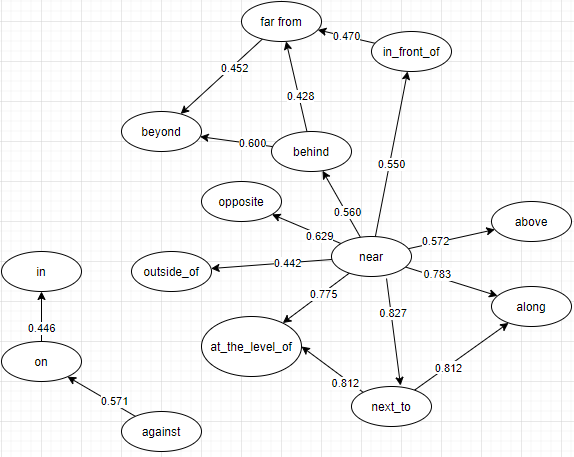